In [1]:
# George Miloshevich 2021
# Perform training

# Importation des librairies
import os as os
import sys
sys.path.insert(1, '../ERA')
from ERA_Fields import* # general routines
from TF_Fields import* # tensorflow routines 
import time
import shutil
import gc
import psutil
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from operator import mul
from functools import reduce

sampling='' #'3hrs' # This chooses whether we want say daily sampling or 3 hour one. Notice that the corresponding NetCDF files are kept in different places
percent = 5 # 1 

timesperday = 8 # 3 hour long periods in case we choose this sampling
if sampling == '3hrs':
    T = 14*timesperday
else:
    T = 14

tau = 0 #-5  # lag
usepipelines = False # if True => Dataset.from_tensor_slices will be used. This is a more advanced method but it takes more RAM and there is a possiblity for memory leaks when repeating training for cross-validation
fullmetrics = True # If True MCC and confusion matrix will be evaluated during training. This makes training slower!

Model = 'Plasim'
area = 'France'
lon_start = 0
lon_end = 128
lat_start = 0 # latitudes start from 90 degrees North Pole
lat_end = 22


#myscratch='/scratch/gmiloshe/PLASIM/'  # where we acess .py files and save output
mylocal='/local/gmiloshe/PLASIM/' #'/local/gmiloshe/PLASIM/'      # where we keep large datasets that need to be loaded
myscratch=TryLocalSource(mylocal)        # Check if the data is not there and can be found in some other source
#myscratch=mylocal

new_mixing = False                     # if set to True the undersampling will also follow the suit

num_years = 8000                       # Select the number of years from the simulation for the analysis


# If an integer >= 1 is chosen we simply undersample by this rate
# If a float between 0 and 1 is chosen we select each state with the probability given by this float
undersampling_factor = 10 # 1 #15 #10 #5 #1 #0.25 #0.15 #0.25
oversampling_factor = 1 # oversampling_factor = 1 means that oversampling will not be performed
thefield = 't2m' # Important: this is the field that is used to determine the extrema (important for undersampling) and therefore the label space

checkpoint_name = 'training/__folder.France14_equalmixed_22by128__/stack_CNN_equalmixed_ckpt_t2mT14France__with_zg500_t2mmrsoFrance__u10o1_8000yrs__per_5_finetune_tau_0'
creation=checkpoint_name
#lat_from = [4,4]     # 18x42
#lat_to   = [22,22]
#lon_from = [101,0]
#lon_to   = [128,15]
lat_from =  [0,0]   # 22x128
lat_to =    [22,22]
lon_from =  [64, 0]
lon_to =    [128, 64]


print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield])

if sampling == '3hrs':
    Months1 = [0, 0, 0, 0, 0, 0, timesperday*30, timesperday*30, timesperday*30, timesperday*30, timesperday*30, 0, 0, 0]
else: # if sampling == 'daily'
    Months1 = [0, 0, 0, 0, 0, 0, 30, 30, 30, 30, 30, 0, 0, 0] 
Tot_Mon1 = list(itertools.accumulate(Months1))

time_start = Tot_Mon1[6]
time_end = Tot_Mon1[9] #+(Tot_Mon1[10]-Tot_Mon1[9])//2   # uncomment this if we are to use full summer (including the portion with september due to T days window)

if sampling == '3hrs': 
    prefix = ''
    file_prefix = '../Climate/'
else:
    prefix = 'ANO_LONG_'
    file_prefix = ''

t2m = Plasim_Field('tas',prefix+'tas','Temperature', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)     # if we want to use surface tempeature
zg500 = Plasim_Field('zg',prefix+'zg500','500 mbar Geopotential', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)
mrso = Plasim_Field('mrso',prefix+'mrso','soil moisture', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)

t2m.years=8000
zg500.years=8000
mrso.years=8000

#ts.load_field(mylocal+file_prefix+'Data_Plasim/')  # load the data
t2m.load_field(mylocal+file_prefix+'Data_Plasim_LONG/')  # load the data
zg500.load_field(mylocal+file_prefix+'Data_Plasim_LONG/')
mrso.load_field(mylocal+file_prefix+'Data_Plasim_LONG/')

LON = t2m.LON
LAT = t2m.LAT
print(t2m.var.dtype,t2m.var.dtype,t2m.var.dtype)

mask, cell_area, lsm = ExtractAreaWithMask(mylocal,Model,area) # extract land sea mask and multiply it by cell area
print(mask)

t2m.abs_area_int, t2m.ano_area_int = t2m.Set_area_integral(area,mask,'PostprocLONG')
zg500.abs_area_int, zg500.ano_area_int = zg500.Set_area_integral(area,mask,'PostprocLONG') 
mrso.abs_area_int, mrso.ano_area_int = mrso.Set_area_integral(area,mask,'PostprocLONG')


# ===Below we filter out just the area of France for mrso====

filter_mask = np.zeros((t2m.var.shape[2],t2m.var.shape[3])) # a mask which sets to zero all values
filter_lat_from = [13, 13]  # defining the domain of 1's
filter_lat_to = [17, 17] 
filter_lon_from = [-1, 0] 
filter_lon_to =  [128, 3] 

for myiter in range(len(filter_lat_from)): # seting values to 1 in the desired domain
        filter_mask[filter_lat_from[myiter]:filter_lat_to[myiter],filter_lon_from[myiter]:filter_lon_to[myiter]] = 1

mrso.var = mrso.var*filter_mask # applying the filter to set to zero all values outside the domain



filename_mixing = t2m.PreMixing(new_mixing,creation,num_years) # load from the folder that we are calling this file from   # NEW MIXING MEANS ALSO NEW UNDERSAMPLING!
zg500.PreMixing(False,creation,num_years) # IT IS IMPORTANT THAT ALL SUBSEQUENT FIELDS BE MIXED (SHUFFLED) THE SAME WAY, otherwise no synchronization!
mrso.PreMixing(False,creation,num_years)
    
print("t2m.var.shape = ", t2m.var.shape)
print("time_end = ", time_end, " ,time_start = ", time_start, " ,T = ", T)

A, A_reshape, threshold, list_extremes, convseq =  t2m.ComputeTimeAverage(time_start,time_end,T,tau, percent)
print("threshold = ",threshold)


filename_mixing = t2m.EqualMixing(A, threshold, new_mixing,creation,num_years)
zg500.EqualMixing(A, threshold, False,creation,num_years)
mrso.EqualMixing(A, threshold, False,creation,num_years)
# Now we have to recompute the extremes:

A, A_reshape, threshold, list_extremes, convseq =  t2m.ComputeTimeAverage(time_start,time_end,T,tau, percent)

# ===== Applying filter to the temperature field: ====
t2m.var = t2m.var*filter_mask # applying the filter to set to zero all values outside the domain

print("threshold = ",threshold)
print(A.dtype)
# Below we reshape into time by flattened array
t2m.abs_area_int_reshape = t2m.ReshapeInto1Dseries(area, mask, Tot_Mon1[6], Tot_Mon1[9], T, tau)
mrso.abs_area_int_reshape = mrso.ReshapeInto1Dseries(area, mask, Tot_Mon1[6], Tot_Mon1[9], T, tau)
print("mrso.abs_area_int_reshape.shape = ", mrso.abs_area_int_reshape.shape)

print("t2m.var.shape = ", t2m.var.shape)

Trying to import basemap
In this environment you cannot import Basemap
Trying to import cartopy


In this environment you cannot import Basemap
2022-07-27 17:29:35.650640: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Successfully imported cartopy
addresswithoutlocal = 'gmiloshe/PLASIM/'
Trying source:  /ClimateDynamics/MediumSpace/ClimateLearningFR/
The source will be:  /ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/
[5, 14, 'Plasim', 'France', 10, [0, 0], [22, 22], [64, 0], [128, 64], 't2m']
Loading field tas
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0 < np.diff(self.time) < 24.0
total time: (time.time() - start_time)

Loading field zg
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0 < np.diff(self.time) < 24.0
total time: (time.time() - start_time)

Loading field mrso
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0 < np.diff(self.time) < 24.0
total time: (time.time() - start_time)

float32 float32 float32
[

In [2]:
%%time
Xs = [t2m.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X = np.concatenate(Xs, axis=2)


## Without Coarse Graining:
Xs = [zg500.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X= np.concatenate([X[:,:,:,np.newaxis], np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

Xs = [mrso.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X= np.concatenate([X, np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

CPU times: user 52.2 s, sys: 1min 29s, total: 2min 21s
Wall time: 2min 21s


In [3]:
%%time
tau=-5
Xs = [t2m.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X5 = np.concatenate(Xs, axis=2)


## Without Coarse Graining:
Xs = [zg500.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X5= np.concatenate([X5[:,:,:,np.newaxis], np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

Xs = [mrso.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X5= np.concatenate([X5, np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

CPU times: user 57 s, sys: 1min 19s, total: 2min 16s
Wall time: 2min 17s


In [4]:
%%time
tau=-10
Xs = [t2m.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X10 = np.concatenate(Xs, axis=2)


## Without Coarse Graining:
Xs = [zg500.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X10= np.concatenate([X10[:,:,:,np.newaxis], np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

Xs = [mrso.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X10= np.concatenate([X10, np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

CPU times: user 56.4 s, sys: 1min 23s, total: 2min 19s
Wall time: 2min 19s


In [5]:
%%time
tau=-15
Xs = [t2m.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X15 = np.concatenate(Xs, axis=2)


## Without Coarse Graining:
Xs = [zg500.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X15= np.concatenate([X15[:,:,:,np.newaxis], np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

Xs = [mrso.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X15= np.concatenate([X15, np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

CPU times: user 55.9 s, sys: 1min 19s, total: 2min 15s
Wall time: 2min 15s


In [6]:
%%time
tau=-20
Xs = [t2m.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X20 = np.concatenate(Xs, axis=2)


## Without Coarse Graining:
Xs = [zg500.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X20= np.concatenate([X20[:,:,:,np.newaxis], np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

Xs = [mrso.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X20= np.concatenate([X20, np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

CPU times: user 56.1 s, sys: 1min 20s, total: 2min 16s
Wall time: 2min 17s


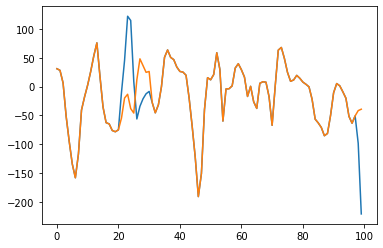

In [7]:
plt.plot(X10[210:310,12,12,1])
plt.plot(X[200:300,12,12,1])

In [8]:
auto_name = "CONTROL_BATCH0001_ts.06"
path = "../Climate/Data_Plasim/" + auto_name + "/"
filename = auto_name + ".0001.nc"
dataset = Dataset(path + filename)
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
dataset.close()
LON, LAT = np.meshgrid(lon, lat)

LATs = [LAT[lat_from1:lat_to1,lon_from1:lon_to1] for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
XLAT = np.concatenate(LATs, axis=1)
LONs = [LON[lat_from1:lat_to1,lon_from1:lon_to1] for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
XLON = np.concatenate(LONs, axis=1)
XLON[:,:np.argmin(XLON[0])] -= 360
XLON1, XLAT1, _ = cplt.Greenwich(XLON, XLAT, XLON)


/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/cartopy_plots.py:134: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, label=colorbar_label, extend='both')


(<cartopy.mpl.contour.GeoContourSet at 0x154caec6c760>,
 <cartopy.mpl.contour.GeoContourSet at 0x154caec6c730>)

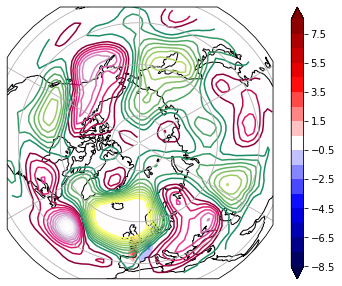

In [9]:
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeat
data_proj = ccrs.PlateCarree()
import cartopy_plots as cplt

t2mlevels = np.linspace(-8.5, 8.5, 18)  # Levels to be used when plotting
zg500levels = np.concatenate((np.arange(-20 * 10, 0, 20), np.arange(20, 10 * 21, 20)))
mrsolevels = np.linspace(-.1, .1, 18)

fig2 = plt.figure(figsize=(30, 5))
i = 0
spec2 = gridspec.GridSpec(ncols=4, nrows=1, figure=fig2)
m = fig2.add_subplot(spec2[0,i], projection=ccrs.Orthographic(central_latitude=90))
#ax.append(m)
m.set_extent([-180,180, 30, 90], crs=data_proj)
cplt.geo_contourf(m, XLON, XLAT, X[0,:,:,0], levels=t2mlevels, cmap="seismic", title=None, put_colorbar=True, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
cplt.geo_contour(m, XLON, XLAT, X[0,:,:,1], levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)

In [10]:
from pathlib import Path
path = Path("test3/0/")
print(path.parent.absolute()/'0')

/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/test3/0


In [11]:
str(path)

'test3/0'

In [28]:
import numpy as np
training_name0 = 'training/__folder.France_equalmixed_22by128__/stack_CNN_ckpt_t2mFrance__with_zg500__22by128_u10o1_LONG8000yrs__per_5_tau_-25'
threshold = np.load(training_name+'/threshold.npy')

training_name0 = 'training/__folder.France14_equalmixed_22by128__/stack_CNN_equalmixed_ckpt_t2mT14France__with_zg500_t2mmrsoFrance__u10o1_8000yrs__per_5_finetune_tau_'

list_extremes_tau = []
committor_tau = []
A_reshape_tau = []


for i, tau in enumerate(range(0,-30,-5)):
    training_name = training_name0+str(tau)
    A_reshape = np.load(training_name+'/A_preshaped.npy')
    A_reshape_tau.append(A_reshape)
    committor = np.load(training_name+'/committor.npy')
    committor_tau.append(committor)
    list_extremes = np.load(training_name+'/list_extremes_preshaped.npy')
    list_extremes_tau.append(list_extremes)
    print("tau = ", tau, " ; A_reshape.shape = ", A_reshape.shape, " ; committor.shape = ", committor.shape, " ; list_extremes.shape = ", list_extremes.shape)


committor_tau_reshape = np.array(committor_tau)
committor_tau = np.array(committor_tau_reshape).reshape(i+1,8000,-1)
A = A_reshape.reshape(8000,-1)
list_extremes = np.array(list_extremes).reshape(8000,-1)
label_assignment = committor_tau>1./11.

tau =  0  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -5  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -10  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -15  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -20  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -25  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)


In [29]:
A_reshape.shape

(616000,)

In [30]:
X10[232,12,12,1]

45.38587951660156

In [31]:
X10[212,12,12,1], X[202,12,12,1]

(6.3770647048950195, 6.3770647048950195)

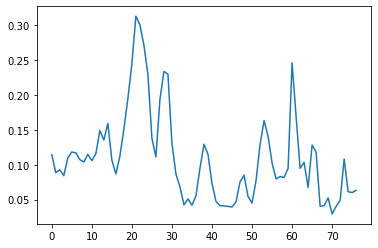

In [32]:
plt.plot(committor_tau[2,0,:100])

In [33]:
np.sum((committor_tau_reshape[0]<np.quantile(committor_tau_reshape[0],1))&(committor_tau_reshape[0]>=np.quantile(committor_tau_reshape[0],0.999)))#/len(committor_tau_reshape[0])

615

In [34]:
np.quantile(committor_tau_reshape[0],1),np.quantile(committor_tau_reshape[0],1)

(0.9960543513298035, 0.9960543513298035)

In [35]:
np.sum(committor_tau_reshape[0]>=0.5)

16337

In [36]:
np.quantile(committor_tau_reshape[0], 0.5, axis=0)

0.0007962605741340667

In [37]:
np.quantile(committor_tau_reshape[0], [0.4, 0.75,0.9, 0.95, 0.975, 0.99, 0.995, 0.999, 0.9995], axis=0)

array([1.80303206e-04, 2.19918974e-02, 1.57676430e-01, 3.32964826e-01,
       5.15160298e-01, 7.14364557e-01, 8.14649614e-01, 9.35565002e-01,
       9.57465955e-01])

tau =  0  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -5  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -10  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -15  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -20  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -25  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau = 0,0.0002,0.0220,np.sum(condition) = 215600
tau = 0,0.0220,0.1577,np.sum(condition) = 92400
tau = 0,0.1577,0.3330,np.sum(condition) = 30800
tau = 0,0.3330,0.5152,np.sum(condition) = 15400
tau = 0,0.5152,0.7144,np.sum(condition) = 9240
tau = 0,0.7144,0.8146,np.sum(condition) = 3080
tau = 0,0.8146,0.9356,np.sum(condition) = 2464
tau

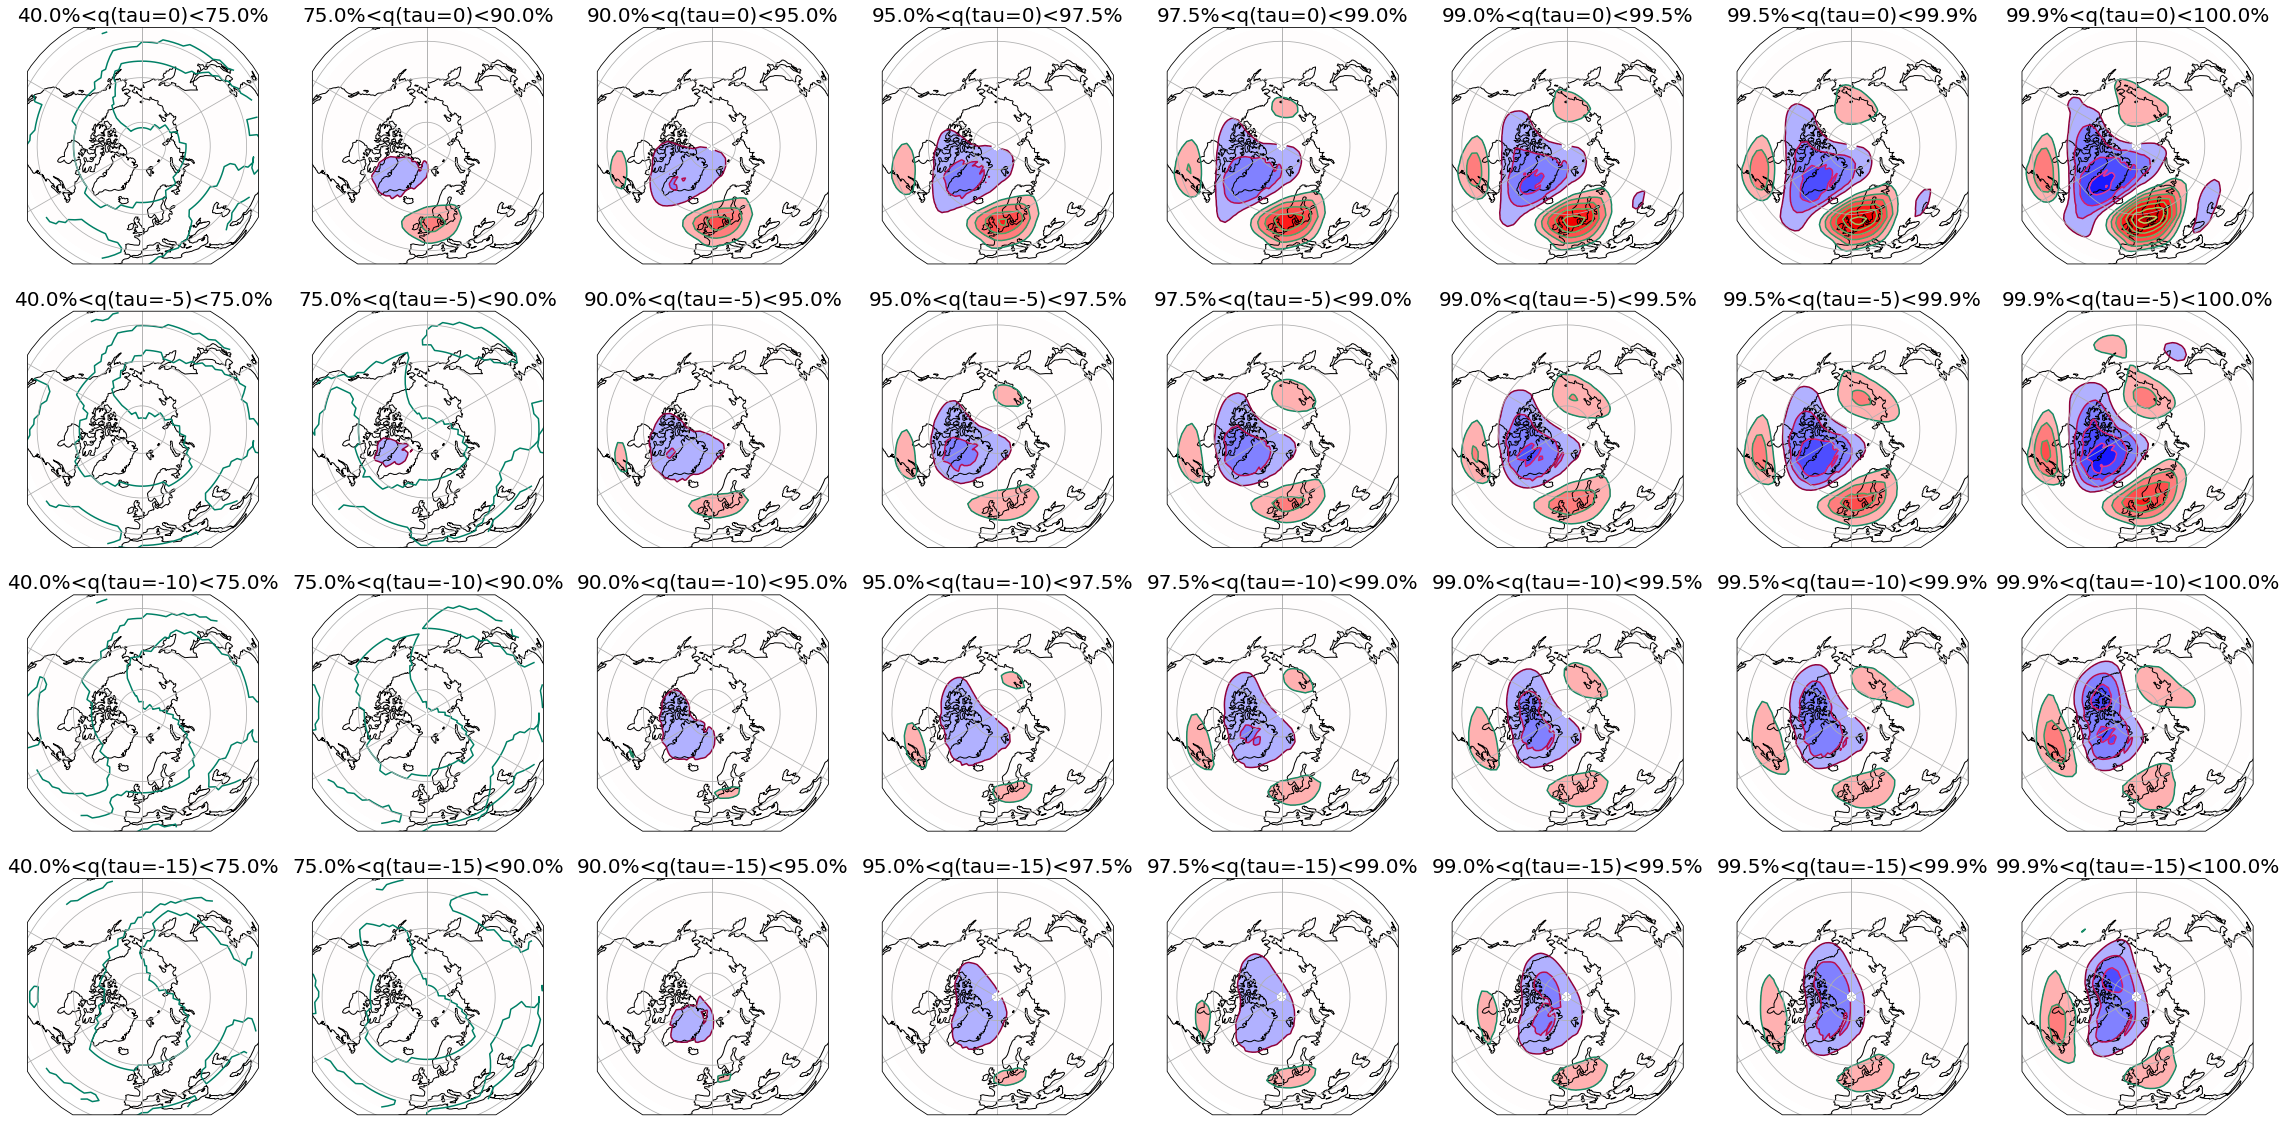

In [40]:
training_name0 = 'training/__folder.France14_equalmixed_22by128__/stack_CNN_equalmixed_ckpt_t2mT14France__with_zg500_t2mmrsoFrance__u10o1_8000yrs__per_5_finetune_tau_'
#training_name0 = 'training/__folder.France_equalmixed_22by128__/stack_CNN_ckpt_t2mFrance__with_zg500__22by128_u10o1_LONG8000yrs__per_5_tau_'
list_extremes_tau = []
committor_tau = []
A_reshape_tau = []


for i, tau in enumerate(range(0,-30,-5)):
    training_name = training_name0+str(tau)
    A_reshape = np.load(training_name+'/A_preshaped.npy')
    A_reshape_tau.append(A_reshape)
    committor = np.load(training_name+'/committor.npy')
    committor_tau.append(committor)
    list_extremes = np.load(training_name+'/list_extremes_preshaped.npy')
    list_extremes_tau.append(list_extremes)
    print("tau = ", tau, " ; A_reshape.shape = ", A_reshape.shape, " ; committor.shape = ", committor.shape, " ; list_extremes.shape = ", list_extremes.shape)

committor_tau_reshape = np.array(committor_tau)
committor_tau = np.array(committor_tau_reshape).reshape(i+1,8000,-1)
A = A_reshape.reshape(8000,-1)
list_extremes = np.array(list_extremes).reshape(8000,-1)
label_assignment = committor_tau>1./11.

t2mlevels = np.linspace(-8.5, 8.5, 18)  # Levels to be used when plotting
zg500levels = np.concatenate((np.arange(-20 * 10, 0, 20), np.arange(20, 10 * 21, 20)))
mrsolevels = np.linspace(-.1, .1, 18)

fig2 = plt.figure(figsize=(40, 20))
spec2 = gridspec.GridSpec(ncols=8, nrows=4, figure=fig2)
for i, tau in enumerate(range(0, -20, -5)):
    quantiles= np.array([40, 75, 90, 95, 97.5, 99, 99.5, 99.9, 100])
    threshs = np.quantile(committor_tau_reshape[i], quantiles/100, axis=0)
    for k in range(len(threshs)-1):
        condition = (committor_tau_reshape[i]>=threshs[k])&(committor_tau_reshape[i]<threshs[k+1])
        print(f"{tau = },{threshs[k]:.4f},{threshs[k+1]:.4f},{np.sum(condition) = }")
        m = fig2.add_subplot(spec2[i,k], projection=ccrs.Orthographic(central_latitude=90))
        #ax.append(m)
        m.set_extent([-180,180, 30, 90], crs=data_proj)
        if tau == 0:
            cplt.geo_contourf(m, XLON, XLAT, np.mean(X[condition,:,:,1],0), levels=zg500levels, cmap="seismic", title=f"{quantiles[k]}%<q(tau={tau})<{quantiles[k+1]}%", put_colorbar=False, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
            cplt.geo_contour(m, XLON, XLAT, np.mean(X[condition,:,:,1],0), levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)
        elif tau == -5:
            cplt.geo_contourf(m, XLON, XLAT, np.mean(X5[condition,:,:,1],0), levels=zg500levels, cmap="seismic", title=f"{quantiles[k]}%<q(tau={tau})<{quantiles[k+1]}%", put_colorbar=False, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
            cplt.geo_contour(m, XLON, XLAT, np.mean(X5[condition,:,:,1],0), levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)
        elif tau == -10:
            cplt.geo_contourf(m, XLON, XLAT, np.mean(X10[condition,:,:,1],0), levels=zg500levels, cmap="seismic", title=f"{quantiles[k]}%<q(tau={tau})<{quantiles[k+1]}%", put_colorbar=False, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
            cplt.geo_contour(m, XLON, XLAT, np.mean(X10[condition,:,:,1],0), levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)
        elif tau == -15:
            cplt.geo_contourf(m, XLON, XLAT, np.mean(X15[condition,:,:,1],0), levels=zg500levels, cmap="seismic", title=f"{quantiles[k]}%<q(tau={tau})<{quantiles[k+1]}%", put_colorbar=False, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
            cplt.geo_contour(m, XLON, XLAT, np.mean(X15[condition,:,:,1],0), levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)

In [45]:
X[:,]

masked_array(
  data=[[ 87.86379884,  87.86379884,  87.86379884, ...,  87.86379884,
          87.86379884,  87.86379884],
        [ 85.09652699,  85.09652699,  85.09652699, ...,  85.09652699,
          85.09652699,  85.09652699],
        [ 82.31291295,  82.31291295,  82.31291295, ...,  82.31291295,
          82.31291295,  82.31291295],
        ...,
        [-82.31291295, -82.31291295, -82.31291295, ..., -82.31291295,
         -82.31291295, -82.31291295],
        [-85.09652699, -85.09652699, -85.09652699, ..., -85.09652699,
         -85.09652699, -85.09652699],
        [-87.86379884, -87.86379884, -87.86379884, ..., -87.86379884,
         -87.86379884, -87.86379884]],
  mask=False,
  fill_value=1e+20)

tau =  0  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -5  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -10  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -15  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -20  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau =  -25  ; A_reshape.shape =  (616000,)  ; committor.shape =  (616000,)  ; list_extremes.shape =  (616000,)
tau = -15,0.1638,0.2665,np.sum(condition) = 615
Images/composite-15_0.png


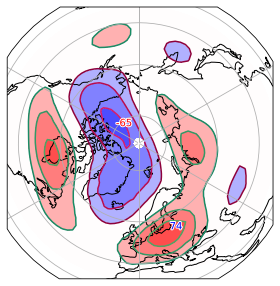

In [61]:
#training_name0 = 'training/__folder.France14_equalmixed_22by128__/stack_CNN_equalmixed_ckpt_t2mT14France__with_zg500_t2mmrsoFrance__u10o1_8000yrs__per_5_finetune_tau_'
training_name0 = 'training/__folder.France_equalmixed_22by128__/stack_CNN_ckpt_t2mFrance__with_zg500__22by128_u10o1_LONG8000yrs__per_5_tau_'
list_extremes_tau = []
committor_tau = []
A_reshape_tau = []


for i, tau in enumerate(range(0,-30,-5)):
    training_name = training_name0+str(tau)
    A_reshape = np.load(training_name+'/A_preshaped.npy')
    A_reshape_tau.append(A_reshape)
    committor = np.load(training_name+'/committor.npy')
    committor_tau.append(committor)
    list_extremes = np.load(training_name+'/list_extremes_preshaped.npy')
    list_extremes_tau.append(list_extremes)
    print("tau = ", tau, " ; A_reshape.shape = ", A_reshape.shape, " ; committor.shape = ", committor.shape, " ; list_extremes.shape = ", list_extremes.shape)

threshold = np.load(training_name+'/threshold.npy')
committor_tau_reshape = np.array(committor_tau)
committor_tau = np.array(committor_tau_reshape).reshape(i+1,8000,-1)
A = A_reshape.reshape(8000,-1)
list_extremes = np.array(list_extremes).reshape(8000,-1)
label_assignment = committor_tau>1./11.

t2mlevels = np.linspace(-8.5, 8.5, 18)  # Levels to be used when plotting
zg500levels = np.concatenate((np.arange(-20 * 10, 0, 20), np.arange(20, 10 * 21, 20)))
mrsolevels = np.linspace(-.1, .1, 18)

fig2 = plt.figure(figsize=(10, 5))
spec2 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig2)
for i, tau in enumerate(range(0, -20, -5)):
    if i == 3:
        quantiles= np.array([99.9, 100])
        threshs = np.quantile(committor_tau_reshape[i], quantiles/100, axis=0)
        for k in range(len(threshs)-1):
            condition = (committor_tau_reshape[i]>=threshs[k])&(committor_tau_reshape[i]<threshs[k+1])
            print(f"{tau = },{threshs[k]:.4f},{threshs[k+1]:.4f},{np.sum(condition) = }")
            m = fig2.add_subplot(spec2[0,k], projection=ccrs.Orthographic(central_latitude=90))
            #ax.append(m)
            m.set_extent([-180,180, 30, 90], crs=data_proj)
            if tau == 0:
                cplt.geo_contourf(m, XLON, XLAT, np.mean(X[condition,:,:,1],0), levels=zg500levels, cmap="seismic", put_colorbar=False, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
                cplt.geo_contour(m, XLON, XLAT, np.mean(X[condition,:,:,1],0), levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)
                cplt.PltMaxMinValue(m,XLON, XLAT, np.mean(X[condition,:,:,1],0))
            elif tau == -5:
                cplt.geo_contourf(m, XLON, XLAT, np.mean(X5[condition,:,:,1],0), levels=zg500levels, cmap="seismic", put_colorbar=False, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
                cplt.geo_contour(m, XLON, XLAT, np.mean(X5[condition,:,:,1],0), levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)
                cplt.PltMaxMinValue(m,XLON, XLAT, np.mean(X5[condition,:,:,1],0))
            elif tau == -10:
                cplt.geo_contourf(m, XLON, XLAT, np.mean(X10[condition,:,:,1],0), levels=zg500levels, cmap="seismic", put_colorbar=False, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
                cplt.geo_contour(m, XLON, XLAT, np.mean(X10[condition,:,:,1],0), levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)
                cplt.PltMaxMinValue(m,XLON, XLAT, np.mean(X10[condition,:,:,1],0))
            elif tau == -15:
                cplt.geo_contourf(m, XLON, XLAT, np.mean(X15[condition,:,:,1],0), levels=zg500levels, cmap="seismic", put_colorbar=False, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
                cplt.geo_contour(m, XLON, XLAT, np.mean(X15[condition,:,:,1],0), levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)
                cplt.PltMaxMinValue(m,XLON, XLAT, np.mean(X15[condition,:,:,1],0))
        fig2.savefig(f'Images/composite{tau}_{k}.png', dpi=200)
        print(f'Images/composite{tau}_{k}.png')